In [1]:
from ansys.mapdl.core import launch_mapdl
import numpy as np
import matplotlib.pyplot as plt

def plot_Deformation(x_N,y_N,ux,uy):
    # --- Settings ---
    scale = 1  # deformation magnification
    mode_color = 'b'
    mode_label = 'Deformed'
    node_marker_size = 6
    node_fill_color = 'yellow'

    # --- Undeformed coordinates ---
    x_orig = x_N
    y_orig = y_N

    # --- Deformed coordinates ---
    x_def = x_orig + scale * ux
    y_def = y_orig + scale * uy

    # --- Plot ---
    plt.figure(figsize=(10, 4))

    # Plot undeformed shape
    plt.plot(x_orig, y_orig, 'k--', label="Undeformed", linewidth=1)

    # Plot deformed shape
    plt.plot(x_def, y_def, color=mode_color, label=mode_label, linewidth=2)
    plt.plot(
        x_def, y_def,
        'o',
        markerfacecolor=node_fill_color,
        markeredgecolor=mode_color,
        markersize=node_marker_size
    )

    # --- Final layout ---
    plt.axis("equal")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Undeformed vs Deformed Shape")
    plt.legend()
    plt.tight_layout()
    plt.grid()
    plt.show()

### Properties of arch

Shallow arch under vertical point load

![alt text](image.png)

In [2]:
R = 40              # radius in m
alpha = 20          # half of open angle in °
n_El = 30           # number of elements
Fref = -140E3       # magnitude of vertical force at top in N

Ex = 2.1E11         # Youngs modulus
nu = 0.3            # Poisson ratio

b = 0.05            # width in m
h = 0.20            # heigth in m

### Discretization
Generate ANSYS input file

In [3]:
# MAPDL starten
mapdl = launch_mapdl(nproc=1)

# Start mapdl and clear it.
mapdl.clear()
mapdl.verify()

# Enter verification example mode and the pre-processing routine.
mapdl.prep7()

# Type of analysis: static.

# Element type: BEAM188.
mapdl.et(1, "188")
# 2D analysis (uy, ux and rotz)
# ! element y axis coincide with global -Z axis
mapdl.keyopt(1, 5, 1)   

# Material type: linear elastic
mapdl.mp("EX", 1, Ex)           # Youngs modulus N/m^2
mapdl.mp("PRXY", 1, nu)             # Poisson ratio

# cross section of beam
mapdl.sectype(1, "Beam", "RECT", "my_sec")  # rectangular cross section
mapdl.secdata(b, h)                         # b (in element y) and h (in element z) in m

# Define nodes
x_N = R*np.sin(np.linspace(np.deg2rad(-alpha), np.deg2rad(alpha), n_El + 1))
y_N = R*np.cos(np.linspace(np.deg2rad(-alpha), np.deg2rad(alpha), n_El + 1))
for i in range(1, n_El+2):
    mapdl.n(i, x_N[i-1], y_N[i-1], 0)

# Define elements
for i in range(1, n_El+1):  
    mapdl.e(i, i+1)

# BC for the beams seats
mapdl.d(1, "UX")
mapdl.d(1, "UY")
mapdl.d(n_El+1, "UY")
mapdl.d(n_El+1, "UX")

# Load at top
mapdl.f(n_El/2+1, "FY", Fref)

mapdl.finish()

***** ROUTINE COMPLETED *****  CP =         0.000

### Solve

In [4]:
mapdl.run("/SOLU")
mapdl.autots("off")
mapdl.antype("STATIC")
mapdl.nlgeom("on")
mapdl.nsubst(10)
mapdl.outres("BASIC","ALL")
#mapdl.pstres("on")
out = mapdl.solve()
mapdl.finish()

FINISH SOLUTION PROCESSING


 ***** ROUTINE COMPLETED *****  CP =         0.000

### Post processing

*****  INDEX OF DATA SETS ON RESULTS FILE  *****

     SET   TIME/FREQ    LOAD STEP   SUBSTEP  CUMULATIVE
       1 0.10000000             1         1         3                  
       2 0.20000000             1         2         5                  
       3 0.30000000             1         3         7                  
       4 0.40000000             1         4         9                  
       5 0.50000000             1         5        11                  
       6 0.60000000             1         6        13                  
       7 0.70000000             1         7        15                  
       8 0.80000000             1         8        17                  
       9 0.90000000             1         9        20                  
      10  1.0000000             1        10        23


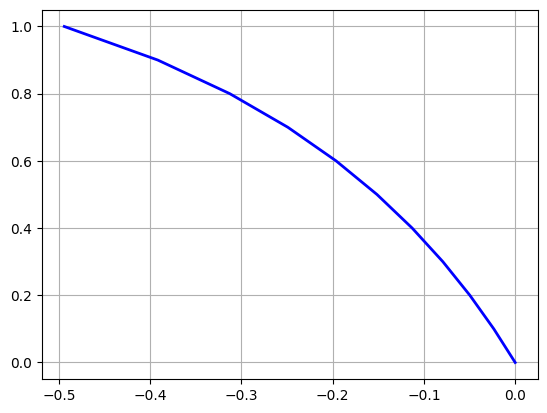

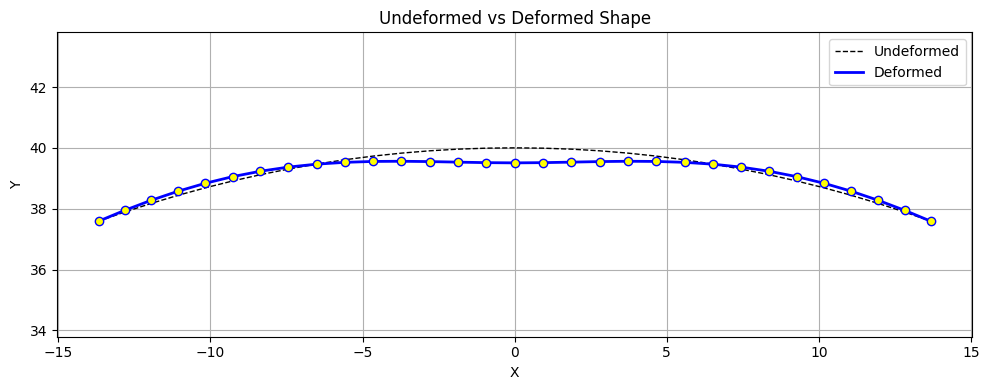

-0.4940709947116399


EXIT THE MAPDL POST1 DATABASE PROCESSOR


 ***** ROUTINE COMPLETED *****  CP =         0.000

In [5]:
# Enter the post-processing routine and select the first load step.
mapdl.post1()

output = mapdl.set("LIST")
print(output)

# monitor DOF
u_monitor = np.zeros((11,2))
for i in range(1,11):
    mapdl.set(1, i)
    u_monitor[i,1] = mapdl.get_value(entity="NODE", entnum=n_El/2+1, item1="u", it1num="y")
    u_monitor[i,0] = mapdl.get_value(entity="ACTIVE", entnum=0, item1="set", it1num="time")

plt.plot(u_monitor[:,1], u_monitor[:,0], color='blue', linewidth=2)
plt.grid()
plt.show()

#mapdl.set(1, 10)

# Get nodal displacements
ux = np.zeros(n_El+1)
uy = np.zeros(n_El+1)
for i in range(0, n_El+1):
    ux[i] = mapdl.get_value(entity="NODE", entnum=i+1, item1="u", it1num="x")
    uy[i] = mapdl.get_value(entity="NODE", entnum=i+1, item1="u", it1num="y")

plot_Deformation(x_N, y_N, ux, uy)

print(uy[int(n_El/2)])

mapdl.finish()

In [7]:
mapdl.exit()